In [6]:
import os, random, math, time
import struct
import numpy as np
import matplotlib.pyplot as plt

In [7]:
image_resolution = 28 * 28
num_classes = 10

learning_rate = 0.1
num_epochs = 20
s = 300
batch_size = 64

In [8]:
def read_images_labels(images_filepath, labels_filepath):
    with open(labels_filepath, 'rb') as file:
        _, size = struct.unpack(">II", file.read(8))
        labels = np.fromfile(file, dtype=np.uint8, count=size)

    with open(images_filepath, 'rb') as file:
        _, size, rows, cols = struct.unpack(">IIII", file.read(16))
        images = np.fromfile(file, dtype=np.uint8, count=size * rows * cols)
        images = images.reshape(size, rows, cols)

    return images, labels

def load_data(training_images_filepath, training_labels_filepath,
              test_images_filepath, test_labels_filepath):
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train), (x_test, y_test)

In [9]:
input_path = "MNIST/"

training_images_filepath = input_path + "train-images-idx3-ubyte/train-images-idx3-ubyte"
training_labels_filepath = input_path + "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_filepath = input_path + "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_filepath = input_path + "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

(x_train, y_train), (x_test, y_test) = load_data(
    training_images_filepath, training_labels_filepath,
    test_images_filepath, test_labels_filepath
)

print(f"Train len: {len(x_train)}, {len(y_train)}")
print(f"Test len: {len(x_test)}, {len(y_test)}")

Train len: 60000, 60000
Test len: 10000, 10000


In [10]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

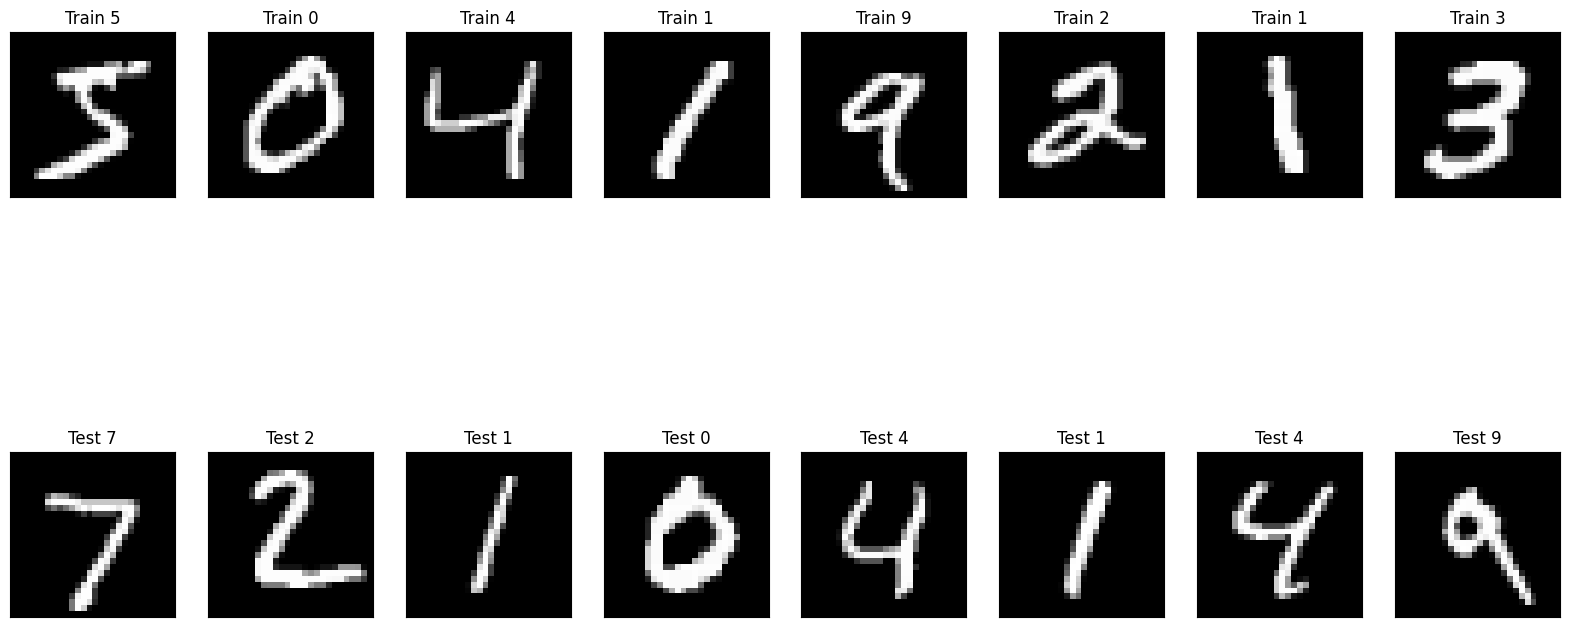

In [11]:
n_samples_show = 8
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 10))

for i in range(n_samples_show):
    axes[0][i].imshow(x_train[i], cmap='gray')
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[0][i].set_title('Train {}'.format(y_train[i]))
    axes[1][i].imshow(x_test[i], cmap='gray')
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])
    axes[1][i].set_title('Test {}'.format(y_test[i]))

In [12]:
class FastTwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Kaiming initialization
        self.W1 = np.random.randn(input_size, hidden_size).astype(np.float32) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros(hidden_size, dtype=np.float32)
        self.W2 = np.random.randn(hidden_size, output_size).astype(np.float32) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros(output_size, dtype=np.float32)

        self.cache = {}

    def forward(self, X):
        # Первый слой
        z1 = X @ self.W1 + self.b1
        # ReLU
        a1 = np.maximum(0, z1)

        # Второй слой
        z2 = a1 @ self.W2 + self.b2
        # Softmax
        exp_scores = np.exp(z2 - np.max(z2, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        self.cache['X'] = X
        self.cache['z1'] = z1
        self.cache['a1'] = a1
        self.cache['probs'] = probs

        return probs

    def backward(self, y_true):
        X = self.cache['X']
        z1 = self.cache['z1']
        a1 = self.cache['a1']
        probs = self.cache['probs']

        batch_size = X.shape[0]

        # Градиент после Softmax
        dZ2 = probs.copy()
        dZ2[np.arange(batch_size), y_true] -= 1
        dZ2 /= batch_size

        # Градиенты второго слоя
        dW2 = a1.T @ dZ2
        db2 = np.sum(dZ2, axis=0)

        # Градиент после ReLU
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (z1 > 0)

        # Градиенты первого слоя
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0)

        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def cross_entropy(self, y_true):
        probs = self.cache['probs']
        batch_size = probs.shape[0]
        loss = -np.log(probs[np.arange(batch_size), y_true] + 1e-8)
        return np.mean(loss)

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

Начальное тестирование
Точность на тесте: 0.0981
Время: 0.0539 секунд

Обучение на 20 эпохах
Эпоха 0: Потери (train) = 0.3517, Потери (test) = 0.2112, Точность (train) = 0.9012, Точность (test) = 0.9379, Время = 5.1001
Эпоха 1: Потери (train) = 0.1843, Потери (test) = 0.1517, Точность (train) = 0.9477, Точность (test) = 0.9551, Время = 5.9905
Эпоха 2: Потери (train) = 0.1362, Потери (test) = 0.1238, Точность (train) = 0.9608, Точность (test) = 0.9633, Время = 4.6941
Эпоха 3: Потери (train) = 0.1090, Потери (test) = 0.1058, Точность (train) = 0.9693, Точность (test) = 0.9672, Время = 4.3424
Эпоха 4: Потери (train) = 0.0906, Потери (test) = 0.0956, Точность (train) = 0.9738, Точность (test) = 0.9711, Время = 4.7255
Эпоха 5: Потери (train) = 0.0772, Потери (test) = 0.0849, Точность (train) = 0.9778, Точность (test) = 0.9737, Время = 4.4414
Эпоха 6: Потери (train) = 0.0670, Потери (test) = 0.0811, Точность (train) = 0.9812, Точность (test) = 0.9764, Время = 4.2264
Эпоха 7: Потери (train) =

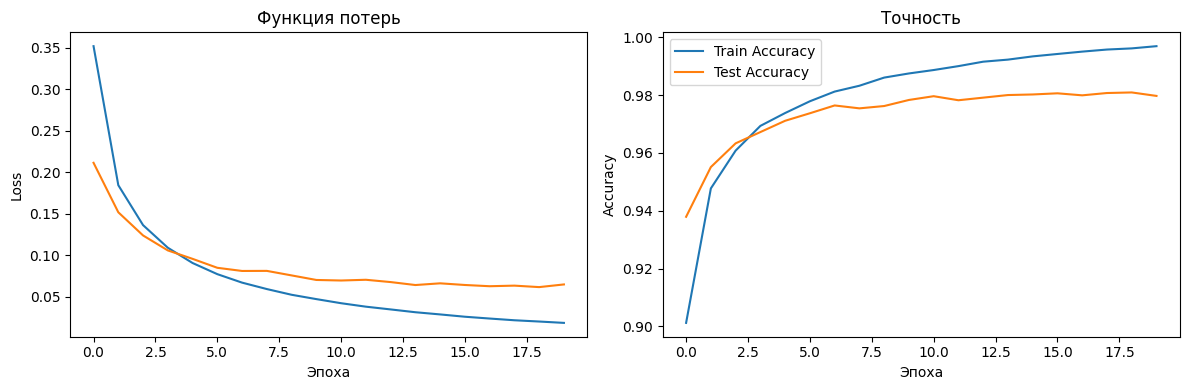

In [13]:
def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size):
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    test_loss_history = []

    train_size = x_train.shape[0]

    x_train_flat = x_train.reshape(train_size, -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    for epoch in range(epochs):
        start_time = time.time()
        indices = np.random.permutation(train_size)
        x_train_shuffled = x_train_flat[indices]
        y_train_shuffled = y_train[indices]

        total_loss = 0.0
        total_correct = 0
        num_batches = 0

        for i in range(0, train_size, batch_size):
            end_idx = min(i + batch_size, train_size)
            X_batch = x_train_shuffled[i:end_idx]
            y_batch = y_train_shuffled[i:end_idx]

            predictions = model.predict(X_batch)

            loss = model.cross_entropy(y_batch)
            
            correct = np.sum(predictions == y_batch)

            total_loss += loss
            total_correct += correct
            num_batches += 1

            dW1, db1, dW2, db2 = model.backward(y_batch)

            model.update_parameters(dW1, db1, dW2, db2)

        avg_loss = total_loss / num_batches
        train_accuracy = total_correct / train_size

        test_predictions = model.predict(x_test_flat)
        test_loss = model.cross_entropy(y_test)
        test_accuracy = np.mean(test_predictions == y_test)

        train_loss_history.append(avg_loss)
        test_loss_history.append(test_loss)
        train_acc_history.append(train_accuracy)
        test_acc_history.append(test_accuracy)

        print(f"Эпоха {epoch}: Потери (train) = {avg_loss:.4f}, "
              f"Потери (test) = {test_loss:.4f}, "
              f"Точность (train) = {train_accuracy:.4f}, "
              f"Точность (test) = {test_accuracy:.4f}, "
              f"Время = {time.time() - start_time:.4f}")

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

def test_model(model, x_test, y_test):
    start_time = time.time()
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    predictions = model.predict(x_test_flat)

    accuracy = np.mean(predictions == y_test)

    print(f"Точность на тесте: {accuracy:.4f}")
    print(f"Время: {time.time() - start_time:.4f} секунд")

    return accuracy

model = FastTwoLayerNet(
    input_size=image_resolution,
    hidden_size=s,
    output_size=num_classes,
    learning_rate=learning_rate
)

print("Начальное тестирование")
init_acc = test_model(model, x_test, y_test)

print(f"\nОбучение на {num_epochs} эпохах")
start_time = time.time()
train_loss, test_loss, train_acc, test_acc = train_model(
    model, x_train, y_train, x_test, y_test,
    epochs=num_epochs, batch_size=batch_size
)

print(f"\nОбучение заняло: {time.time() - start_time:.2f} секунд")

print("\nФинальное тестирование")
final_acc = test_model(model, x_test, y_test)

print(f"\nУлучшение точности: {final_acc - init_acc:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
